# İmport Libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [2]:
# Data loading function
def load_data():
    data = pd.read_csv("cafe_sales.csv")   # Load CSV file
    return data

# Checking the basic properties of data 
def check_data(dataframe):
    print("Head:")
    print(dataframe.head())
    print("  ")
    print("Info:")
    print(dataframe.info())
    print("  ")
    print("Shape:")
    print(dataframe.shape)
    print("  ")
    print("Isnull:")
    print(dataframe.isnull().sum()) 
    print("  ")
    print("describe:")
    print(dataframe.describe().T) 

# Load Dataset
df = load_data()
check_data(df)  # Check Data

Head:
  Transaction ID    Item Quantity Price Per Unit Total Spent  Payment Method  Location Transaction Date
0    TXN_1961373  Coffee        2            2.0         4.0     Credit Card  Takeaway       2023-09-08
1    TXN_4977031    Cake        4            3.0        12.0            Cash  In-store       2023-05-16
2    TXN_4271903  Cookie        4            1.0       ERROR     Credit Card  In-store       2023-07-19
3    TXN_7034554   Salad        2            5.0        10.0         UNKNOWN   UNKNOWN       2023-04-27
4    TXN_3160411  Coffee        2            2.0         4.0  Digital Wallet  In-store       2023-06-11
  
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9

# Data type conversion

Transformation of the types of variables in the data set

In [3]:
df["Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce")
df["Price Per Unit"] = pd.to_numeric(df["Price Per Unit"], errors="coerce")
df["Total Spent"] = pd.to_numeric(df["Total Spent"], errors="coerce")
df["Transaction Date"] = pd.to_datetime(df["Transaction Date"], errors="coerce")

# Categorical variables
df['Item'] = df['Item'].astype('category')  
df['Payment Method'] = df['Payment Method'].astype('category')  
df['Location'] = df['Location'].astype('category')  

# Replace ‘ERROR’ and ‘UNKNOWN’ values with NaN
df.replace(["ERROR", "UNKNOWN"], np.nan, inplace=True)
df.info() # Check variables types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    10000 non-null  object        
 1   Item              9031 non-null   category      
 2   Quantity          9521 non-null   float64       
 3   Price Per Unit    9467 non-null   float64       
 4   Total Spent       9498 non-null   float64       
 5   Payment Method    6822 non-null   category      
 6   Location          6039 non-null   category      
 7   Transaction Date  9540 non-null   datetime64[ns]
dtypes: category(3), datetime64[ns](1), float64(3), object(1)
memory usage: 420.7+ KB


# Missing Values

In [4]:
df.isna().sum()

Transaction ID         0
Item                 969
Quantity             479
Price Per Unit       533
Total Spent          502
Payment Method      3178
Location            3961
Transaction Date     460
dtype: int64

**Let's fill the missing values in Quantity, Price Per Unit and Total Spent variables.**

In [5]:
def fill_missing_values(df):
   #- Total Spent variable can be calculated by multiplying if Quantity and Price Per Unit are full.
    #- Price Per Unit variable can be calculated if Total Spent and Quantity are full.
    #- Quantity variable can be calculated if Total Spent and Price Per Unit are full..
    df["Total Spent"] = df["Total Spent"].fillna(
        (df["Quantity"] * df["Price Per Unit"]).where(df["Quantity"].notna() & df["Price Per Unit"].notna()))

    df["Price Per Unit"] = df["Price Per Unit"].fillna(
        (df["Total Spent"] / df["Quantity"]).where(df["Total Spent"].notna() & df["Quantity"].notna()))

    df["Quantity"] = df["Quantity"].fillna(
        (df["Total Spent"] / df["Price Per Unit"]).where(df["Total Spent"].notna() & df["Price Per Unit"].notna()))

    return df

df = fill_missing_values(df)
df.isna().sum()

Transaction ID         0
Item                 969
Quantity              38
Price Per Unit        38
Total Spent           40
Payment Method      3178
Location            3961
Transaction Date     460
dtype: int64

**Let's count the unique values in the ‘Item’ variable, find their price per unit. Let's also calculate how many units of each product were sold on average.**

In [6]:
df.groupby("Item",observed=False).agg({"Price Per Unit" :"mean",
                        "Quantity": "mean"})

,Price Per Unit,Quantity
Item,,
Cake,3.000,3.050
Coffee,2.000,3.049
Cookie,1.000,2.970
Juice,3.000,3.001
Salad,5.000,3.029
Sandwich,4.000,3.041
Smoothie,4.000,3.049
Tea,1.500,3.037


In [7]:
# We fill the missing values in the ‘Price Per Unit’ variable with the average (unit price) of the products in the ‘Item’ variable 
df.loc[df["Price Per Unit"].isnull(), "Price Per Unit"] = df.groupby("Item",observed=False)["Price Per Unit"].transform("mean")

# We fill the missing ‘Quantity’ values with the average ‘Quantity’ value of the Item group
df.loc[df["Quantity"].isnull(), "Quantity"] = df.groupby("Item",observed=False)["Quantity"].transform("mean")

# We call the function again, filling in the missing values for ‘Price Per Unit’, ‘Quantity’ and ‘Total Spent’.
df = fill_missing_values(df)

df.isna().sum() # Check again null values

Transaction ID         0
Item                 969
Quantity               3
Price Per Unit         6
Total Spent            3
Payment Method      3178
Location            3961
Transaction Date     460
dtype: int64

**Fill in the missing values in the ‘Item’ variable.**

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    10000 non-null  object        
 1   Item              9031 non-null   category      
 2   Quantity          9997 non-null   float64       
 3   Price Per Unit    9994 non-null   float64       
 4   Total Spent       9997 non-null   float64       
 5   Payment Method    6822 non-null   category      
 6   Location          6039 non-null   category      
 7   Transaction Date  9540 non-null   datetime64[ns]
dtypes: category(3), datetime64[ns](1), float64(3), object(1)
memory usage: 420.7+ KB


In [9]:
df.isnull().sum()

Transaction ID         0
Item                 969
Quantity               3
Price Per Unit         6
Total Spent            3
Payment Method      3178
Location            3961
Transaction Date     460
dtype: int64

In [10]:
# We fill in the missing values in the ‘Item’ variable according to the values matching the ‘Price Per Unit’
price_to_item = {
    3.000: "Juice",
    2.000: "Coffee",
    1.000: "Cookie",
    3.000: "Cake",
    5.000: "Salad",
    4.000: "Sandwich",
    4.000: "Smoothie",
    1.500: "Tea"
}

df["Item_New"] = df["Item"].copy()
df.loc[df["Item_New"].isnull(), "Item_New"] = df["Price Per Unit"].map(price_to_item)
df["Item"] = df["Item_New"]
df.drop(columns=["Item_New"], inplace=True)
df.isna().sum()

Transaction ID         0
Item                   6
Quantity               3
Price Per Unit         6
Total Spent            3
Payment Method      3178
Location            3961
Transaction Date     460
dtype: int64

In [11]:
# Filling with average again for ‘Quantity’
df.loc[df["Quantity"].isnull(), "Quantity"] = df.groupby("Item",observed=False)["Quantity"].transform("mean")

# We filled the missing values of ‘Price Per Unit’ with the average
df.loc[df["Price Per Unit"].isnull(), "Price Per Unit"] = df["Price Per Unit"].mean()

# We filled the missing values of ‘Item’ with mode (the most frequent value)
df.loc[df["Item"].isnull(), "Item"] = df["Item"].mode()[0]

df = fill_missing_values(df)  # We call the function again, filling in the missing values for ‘Price Per Unit’, ‘Quantity’ and ‘Total Spent’.
df.isnull().sum()

Transaction ID         0
Item                   0
Quantity               0
Price Per Unit         0
Total Spent            0
Payment Method      3178
Location            3961
Transaction Date     460
dtype: int64

**Fill in missing data on the ‘Payment Method’ variable**

In [12]:
print(f"Null Values:{df['Payment Method'].isna().sum()}\n\n{df['Payment Method'].value_counts()}")

Null Values:3178

Payment Method
Digital Wallet    2291
Credit Card       2273
Cash              2258
Name: count, dtype: int64


In [13]:
payment_probs = df["Payment Method"].value_counts(normalize=True)  # Calculate the distribution of Payment Methods

# Filling in missing ‘Payment Method’ values according to random distribution
df.loc[df["Payment Method"].isna(), "Payment Method"] = np.random.choice(
    payment_probs.index,
    size=df["Payment Method"].isna().sum(),
    p=payment_probs.values)

df.isnull().sum()

Transaction ID         0
Item                   0
Quantity               0
Price Per Unit         0
Total Spent            0
Payment Method         0
Location            3961
Transaction Date     460
dtype: int64

**Fill in missing values on the ‘Location’ variable**

In [14]:
print(f"Null Values:{df['Location'].isna().sum()}\n\n{df['Location'].value_counts()}")

Null Values:3961

Location
Takeaway    3022
In-store    3017
Name: count, dtype: int64


In [15]:
location_probs = df["Location"].value_counts(normalize=True)  # Calculate the distribution of Location

# Filling in missing ‘Location’ values according to random distribution
df.loc[df["Location"].isna(), "Location"] = np.random.choice(
    location_probs.index,  # Location options ["Takeaway","In-stor"]
    size=df["Location"].isna().sum(),
    p=location_probs.values)

df.isnull().sum()

Transaction ID        0
Item                  0
Quantity              0
Price Per Unit        0
Total Spent           0
Payment Method        0
Location              0
Transaction Date    460
dtype: int64

**Fill in missing data on the ‘Transaction Date’ variable**

We can replace the missing values in the ‘Transaction Date’ variable in several different ways.
- Determining the 20 days with the most transactions and filling these missing values with these 20 days
- Fill the missing value with the previous value or the next value using the ffill() or bfill() methods
- If there is missing data in very few observations in our data set, deletion can be used.

In [16]:
df["Transaction Date"].value_counts().head()  # Show the 5 most common values of Transaction Date

Transaction Date
2023-06-16    40
2023-02-06    40
2023-09-21    39
2023-03-13    39
2023-07-24    39
Name: count, dtype: int64

In [17]:
transaction_date_probs = df["Transaction Date"].value_counts(normalize=True).head(20)  # Calculate probabilities for the 20 most common dates
transaction_date_probs = transaction_date_probs / transaction_date_probs.sum()  # The sum of the probabilities must be 1

df.loc[df["Transaction Date"].isna(), "Transaction Date"] = np.random.choice(
    transaction_date_probs.index,  # Transaction Date options
    size=df["Transaction Date"].isna().sum(),  # Select the number of missing rows
    p=transaction_date_probs.values)  #  Determining the probabilities of elections

In [18]:
# We fill in the missing dates using the previous and next value
df["Transaction Date"] = df["Transaction Date"].ffill()  # Fill using the previous value
df["Transaction Date"] = df["Transaction Date"].bfill()  # Fill using the next value

In [19]:
# Delete missing values
df = df.dropna(subset=["Transaction Date"])

In [20]:
df.isna().sum()

Transaction ID      0
Item                0
Quantity            0
Price Per Unit      0
Total Spent         0
Payment Method      0
Location            0
Transaction Date    0
dtype: int64

In [21]:
#saving the cleaned data set
df.to_csv("cleaned_dataset.csv",index=False)

# Detecting outliers

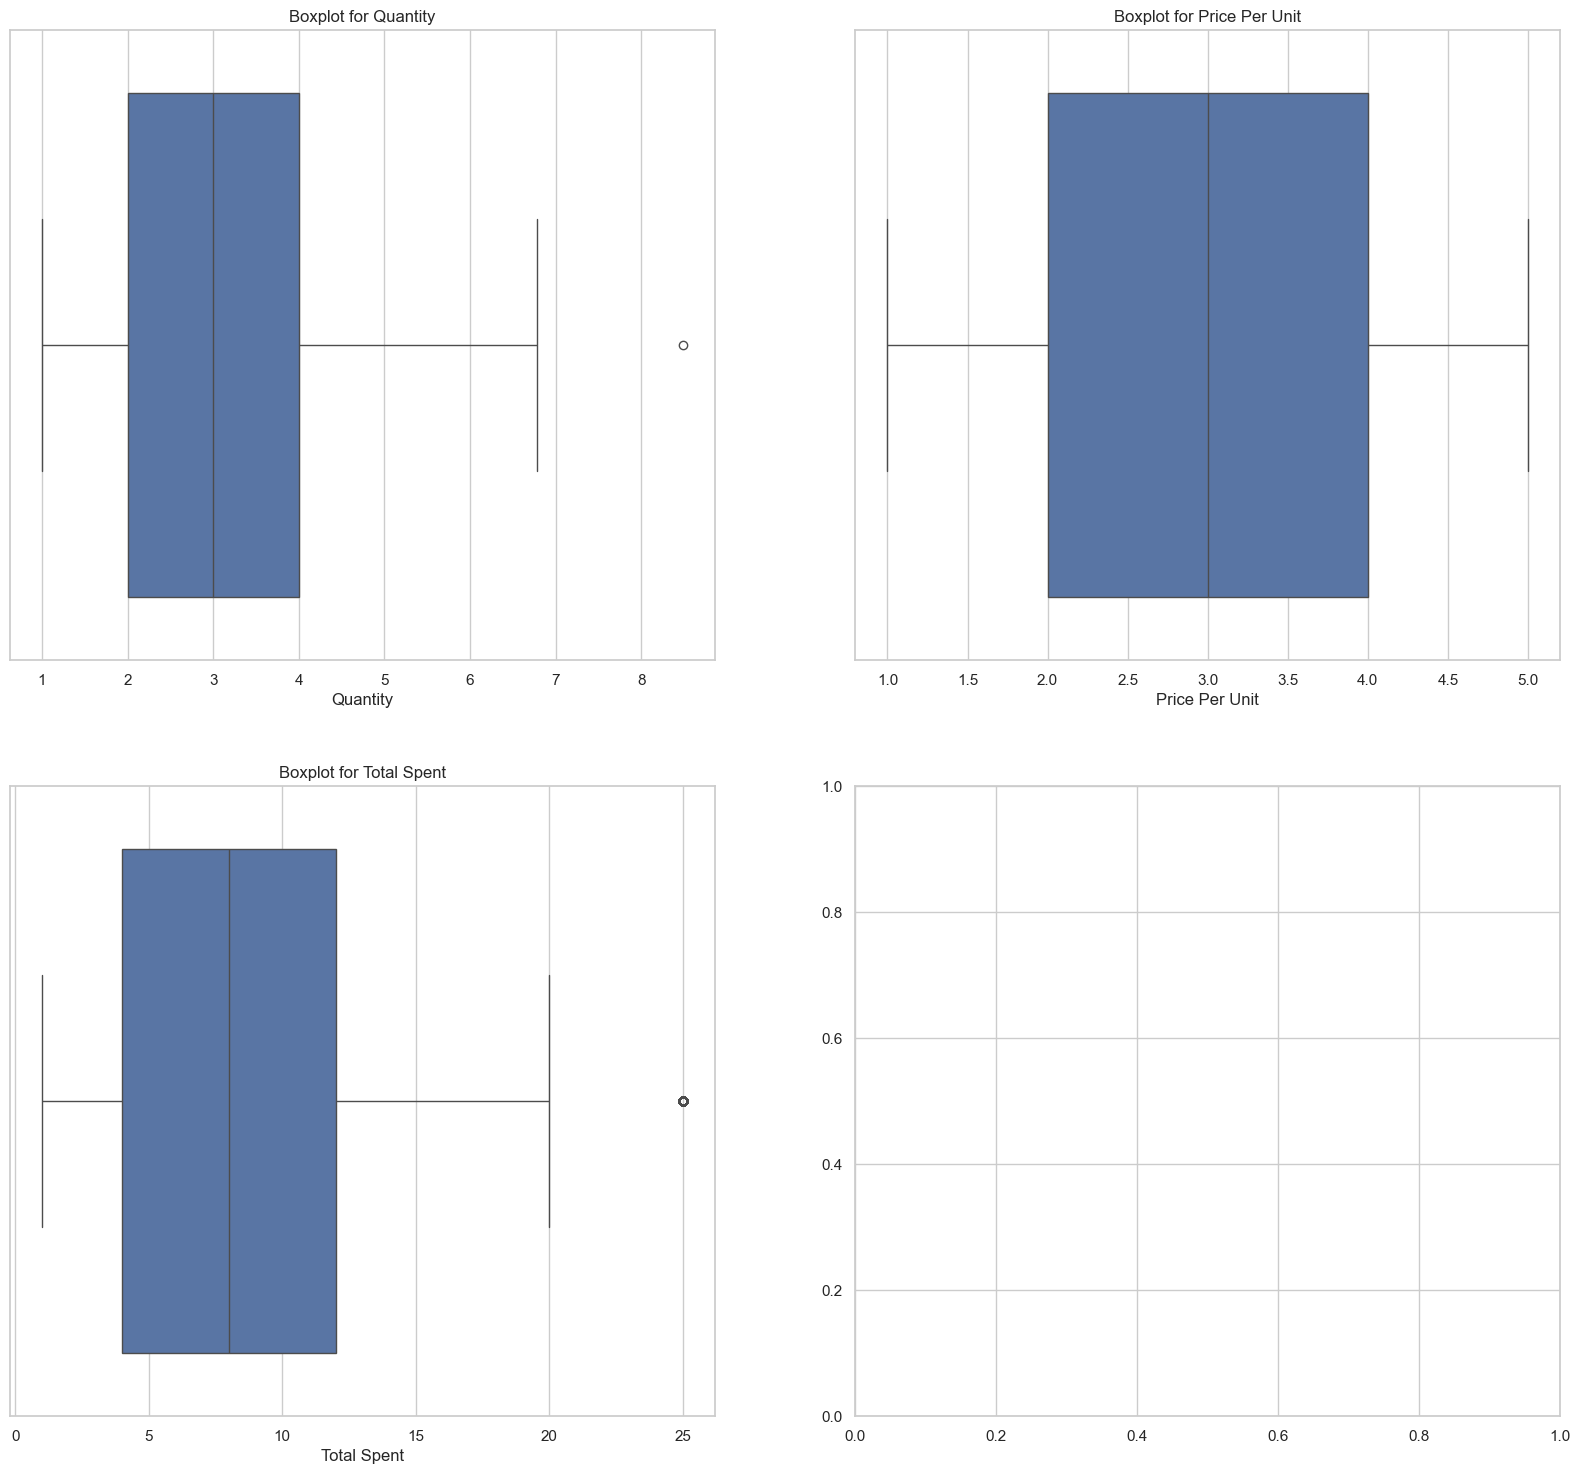

In [22]:
sns.set(style="whitegrid")  # Let's set the graphic style

# Let's create boxplots for different variables
fig, axes = plt.subplots(2, 2, figsize=(20, 18))

sns.boxplot(x=df["Quantity"], ax=axes[0, 0])  # Boxplot for quantity
axes[0, 0].set_title("Boxplot for Quantity")

sns.boxplot(x=df["Price Per Unit"], ax=axes[0, 1])  # Boxplot for Price Per Unit
axes[0, 1].set_title("Boxplot for Price Per Unit")

sns.boxplot(x=df["Total Spent"], ax=axes[1, 0])  # Boxplot for Total Spent
axes[1, 0].set_title("Boxplot for Total Spent")

plt.show()

# Exploratory Data Analysis

# Univariate Analysis

In [23]:
#univariate Analysis
print("Summary Statistics:\n", df.describe())
    
categorical_columns = ['Item', 'Payment Method', 'Location']
for col in categorical_columns:
    print(f"\nValue Counts for {col}:\n", df[col].value_counts())

Summary Statistics:
        Quantity  Price Per Unit  Total Spent            Transaction Date
count 10000.000       10000.000    10000.000                       10000
mean      3.027           2.947        8.931  2023-07-01 07:38:21.120000
min       1.000           1.000        1.000         2023-01-01 00:00:00
25%       2.000           2.000        4.000         2023-04-01 00:00:00
50%       3.000           3.000        8.000         2023-06-30 00:00:00
75%       4.000           4.000       12.000         2023-10-01 00:00:00
max       8.483           5.000       25.000         2023-12-31 00:00:00
std       1.419           1.280        6.000                         NaN

Value Counts for Item:
 Item
Cake        1392
Smoothie    1323
Coffee      1291
Salad       1272
Cookie      1213
Tea         1207
Juice       1171
Sandwich    1131
Name: count, dtype: int64

Value Counts for Payment Method:
 Payment Method
Digital Wallet    3378
Credit Card       3312
Cash              3310
Name: count

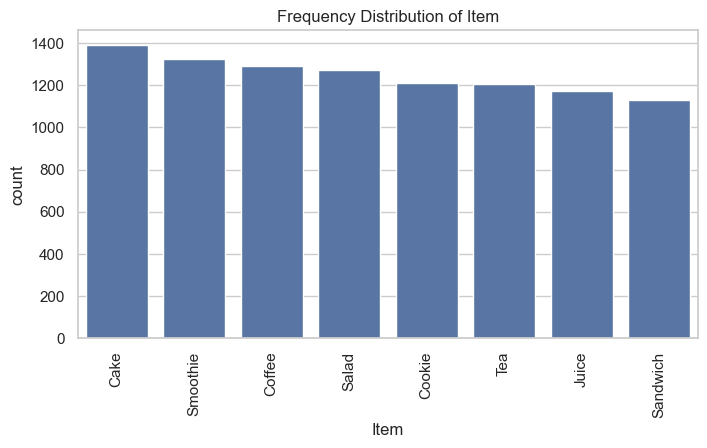

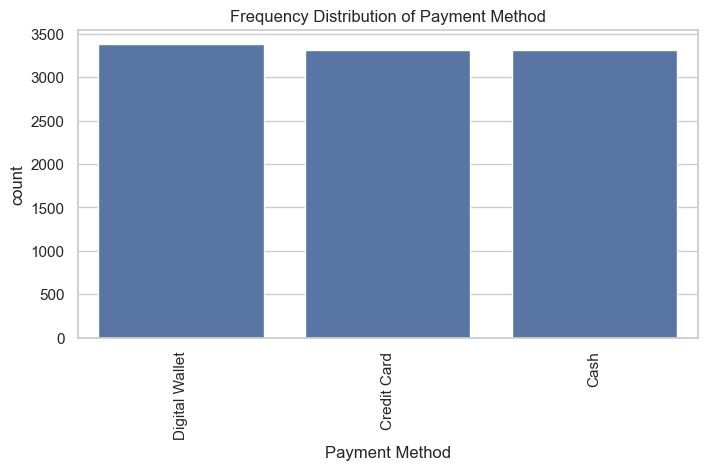

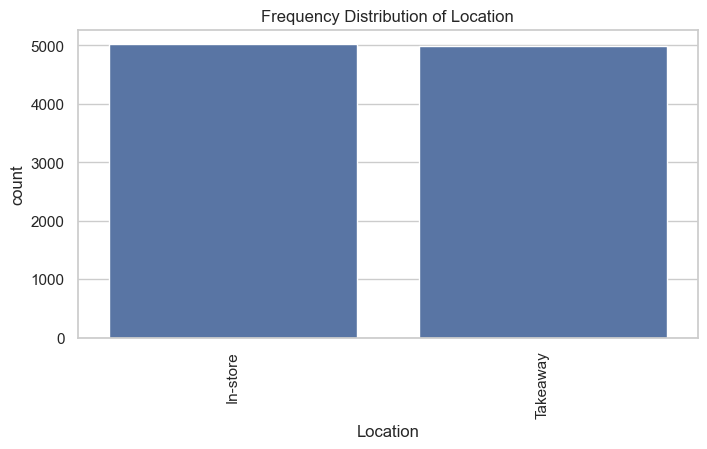

In [49]:
# Frequency distributions for categorical variables
for cat in categorical_vars:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=df[cat], order=df[cat].value_counts().index)
    plt.xticks(rotation=90)
    plt.title(f"Frequency Distribution of {cat}")
    plt.show()

**Histograms**

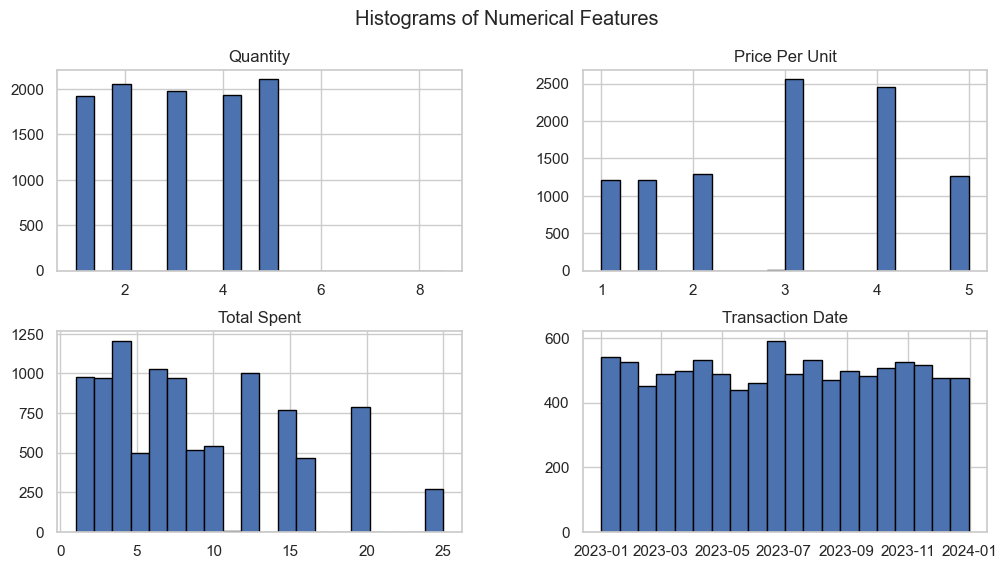

In [24]:
# Histograms for numerical variables
df.hist(figsize=(12, 6), bins=20, edgecolor='black')
plt.suptitle("Histograms of Numerical Features")
plt.show()

**Box Plots**

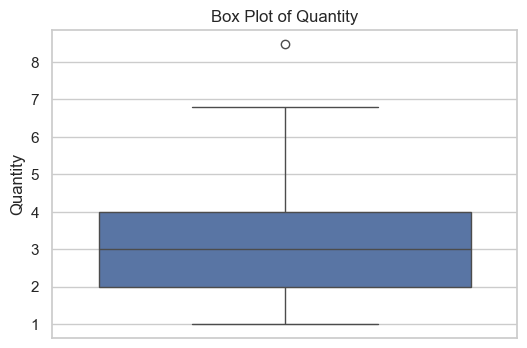

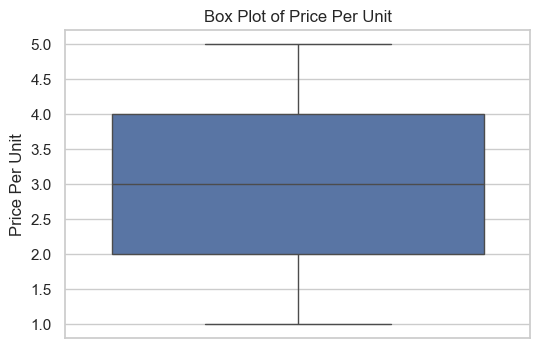

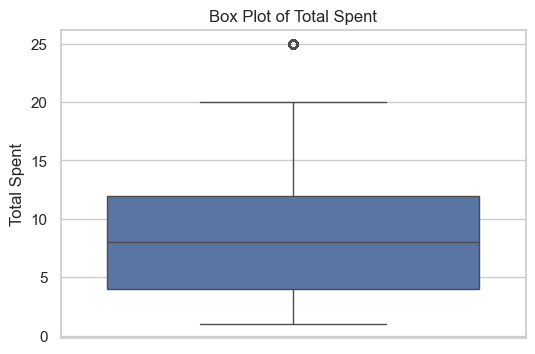

In [25]:
 # Box plots for numerical variables
for col in ['Quantity', 'Price Per Unit', 'Total Spent']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df[col])
    plt.title(f"Box Plot of {col}")
    plt.show()

 # Bivariate Analysis

In [26]:
# Correlation matrix for numerical variables
num_cols = df.select_dtypes(include=['number']).columns
correlation_matrix = df[num_cols].corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                Quantity  Price Per Unit  Total Spent
Quantity           1.000           0.007        0.704
Price Per Unit     0.007           1.000        0.647
Total Spent        0.704           0.647        1.000


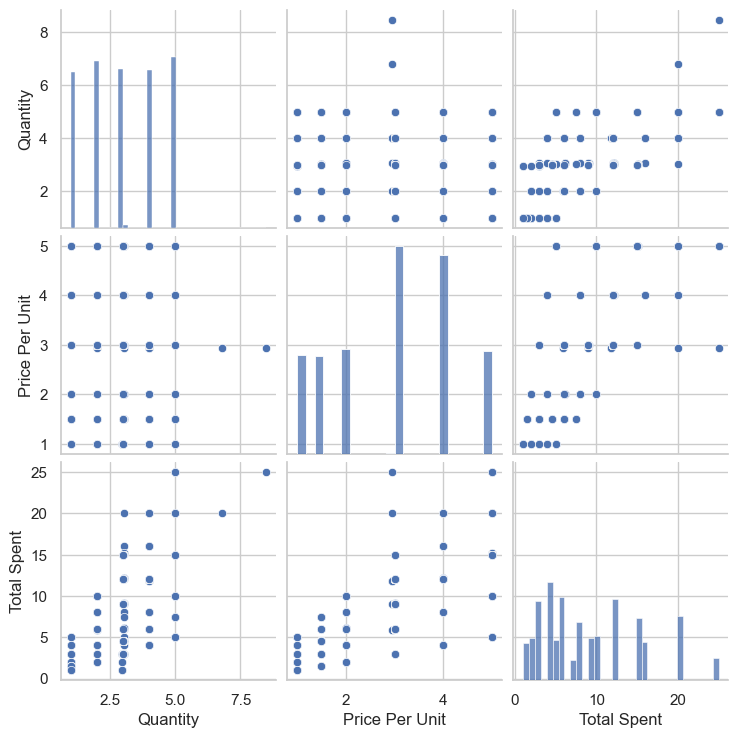

In [27]:
    # Scatter plots
    sns.pairplot(df.select_dtypes(include=['number']))
    plt.show()

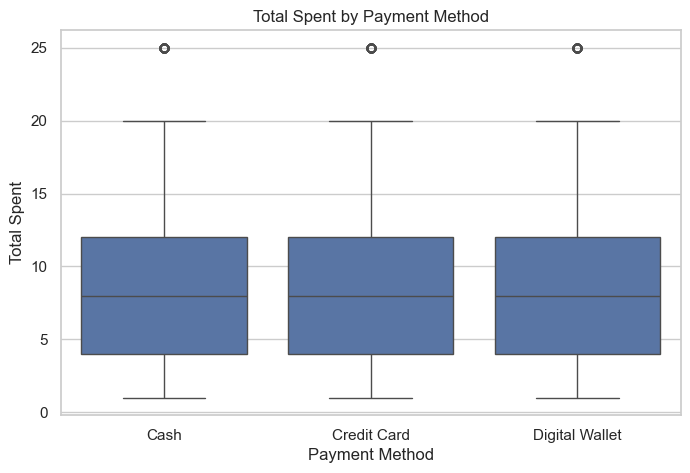

In [29]:
    # Box plot: Total Spent by Payment Method
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Payment Method', y='Total Spent', data=df)
    plt.title("Total Spent by Payment Method")
    plt.show()

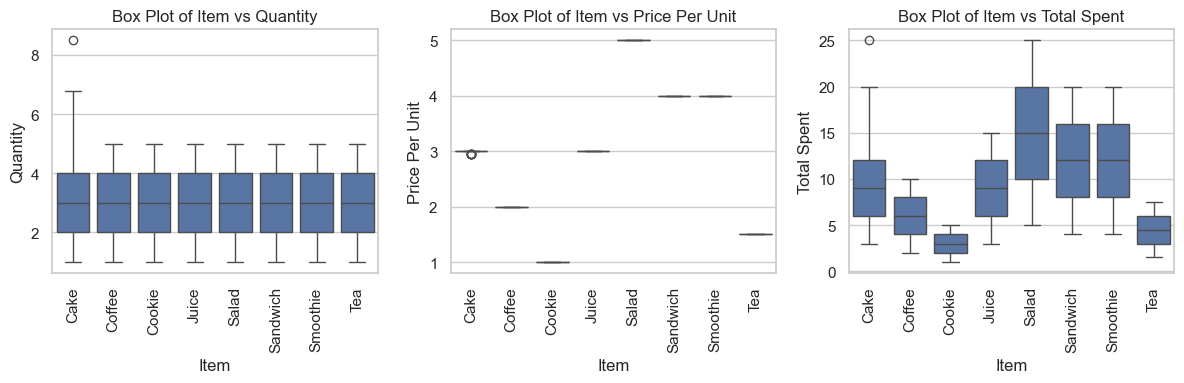

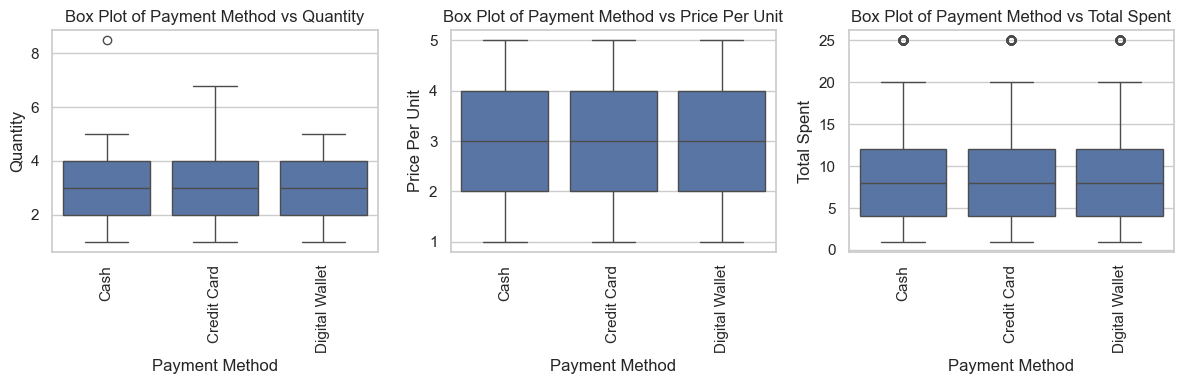

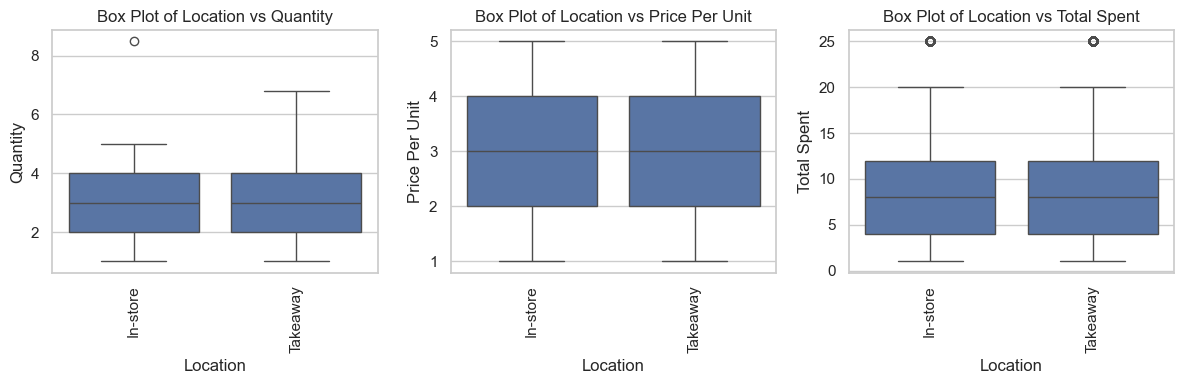

In [50]:
# Box plots for categorical vs numerical variables
for cat in categorical_vars:
    plt.figure(figsize=(12, 4))
    for i, num in enumerate(numerical_vars, 1):
        plt.subplot(1, 3, i)
        sns.boxplot(x=df[cat], y=df[num])
        plt.xticks(rotation=90)
        plt.title(f"Box Plot of {cat} vs {num}")
    plt.tight_layout()
    plt.show()


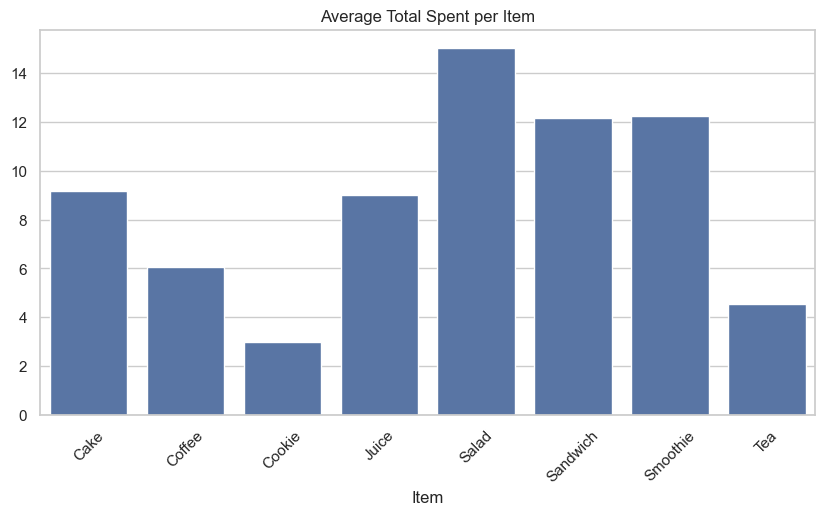

In [30]:
    # Bar plot: Average Total Spent per Item
    plt.figure(figsize=(10, 5))
    sns.barplot(x=df.groupby("Item")["Total Spent"].mean().index, 
                y=df.groupby("Item")["Total Spent"].mean().values)
    plt.xticks(rotation=45)
    plt.title("Average Total Spent per Item")
    plt.show()

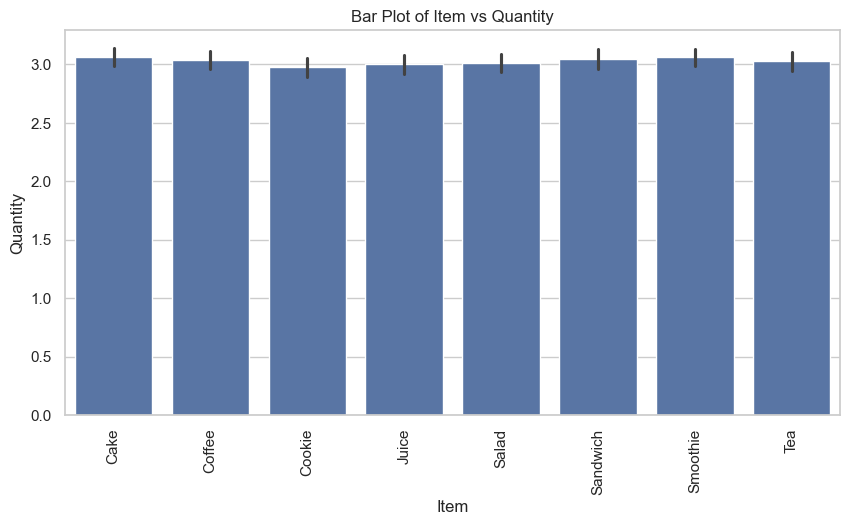

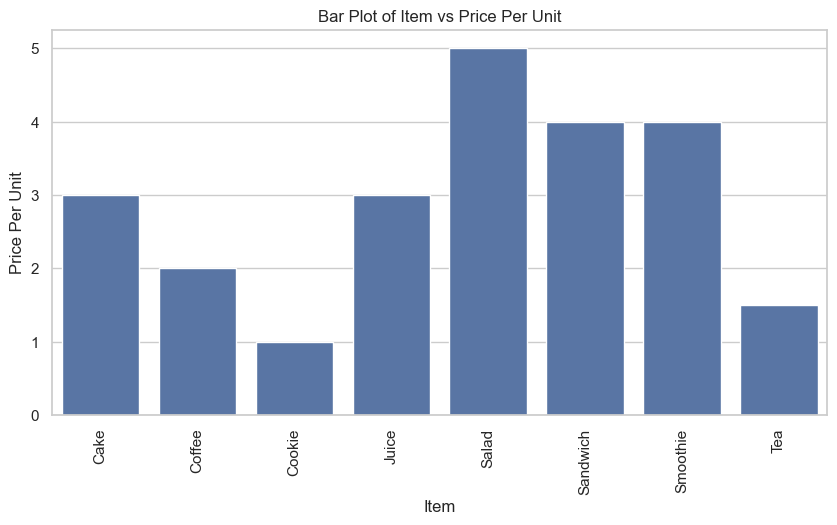

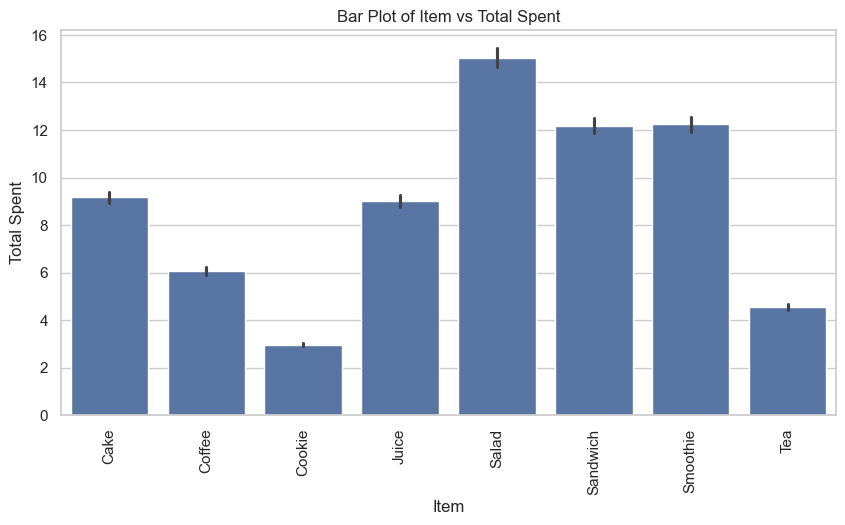

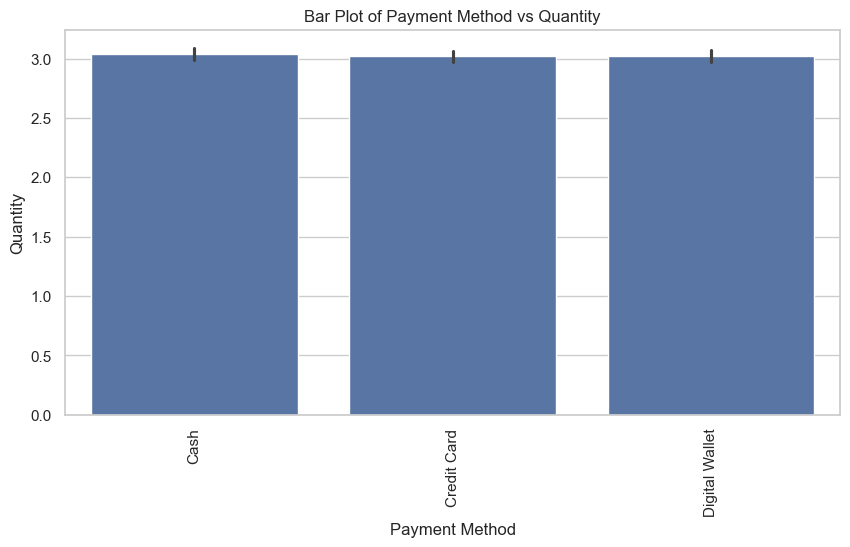

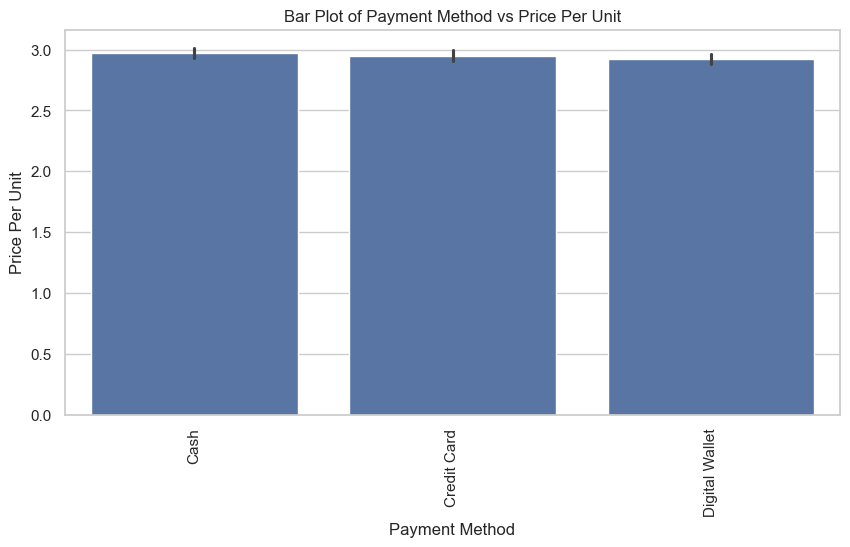

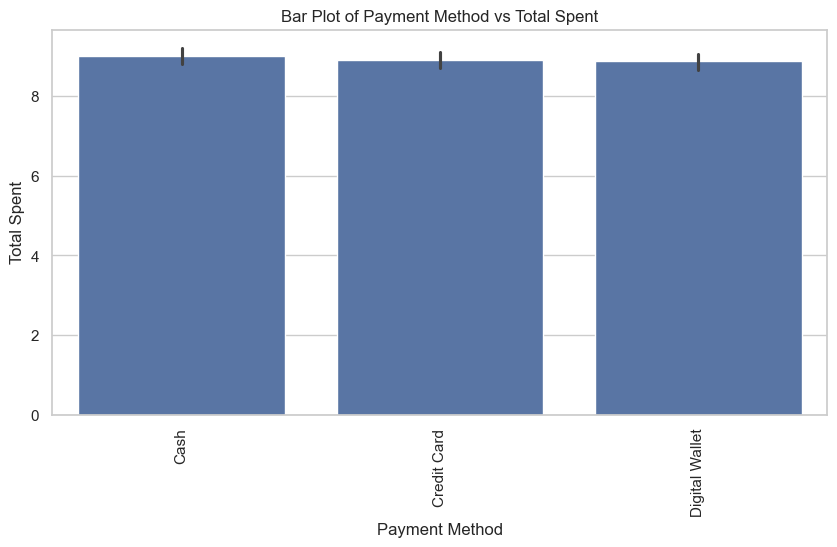

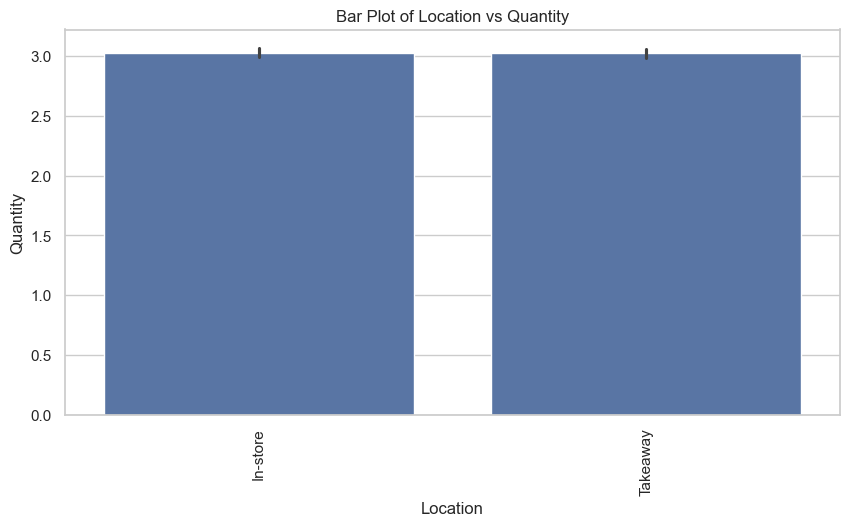

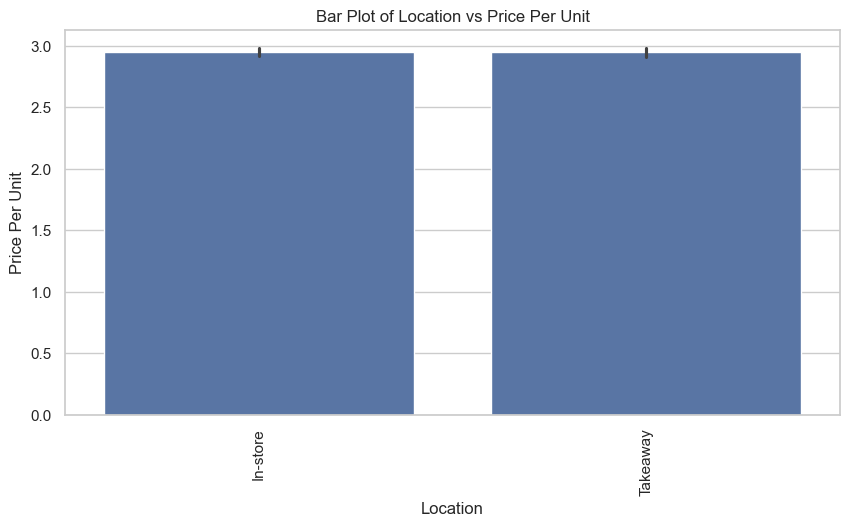

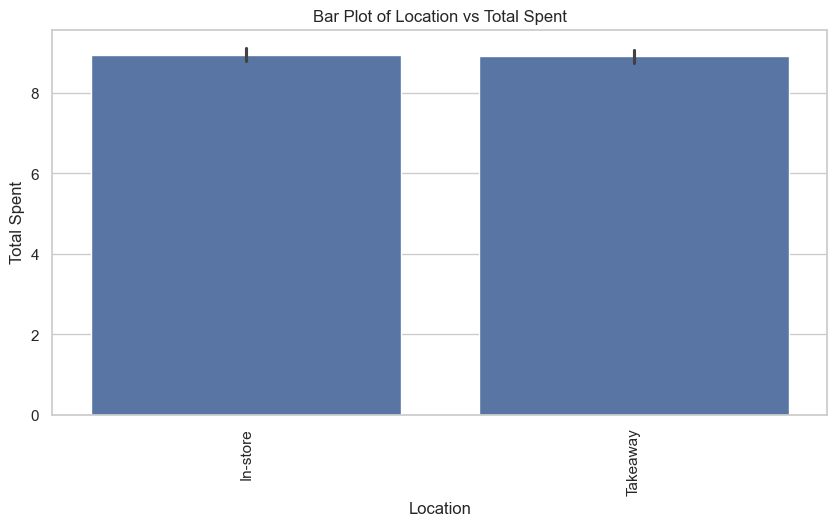

In [42]:
# Bar plots for categorical vs numerical variables
for cat in categorical_vars:
    for num in numerical_vars:
        plt.figure(figsize=(10, 5))
        sns.barplot(x=df[cat], y=df[num])
        plt.xticks(rotation=90)
        plt.title(f"Bar Plot of {cat} vs {num}")
        plt.show()

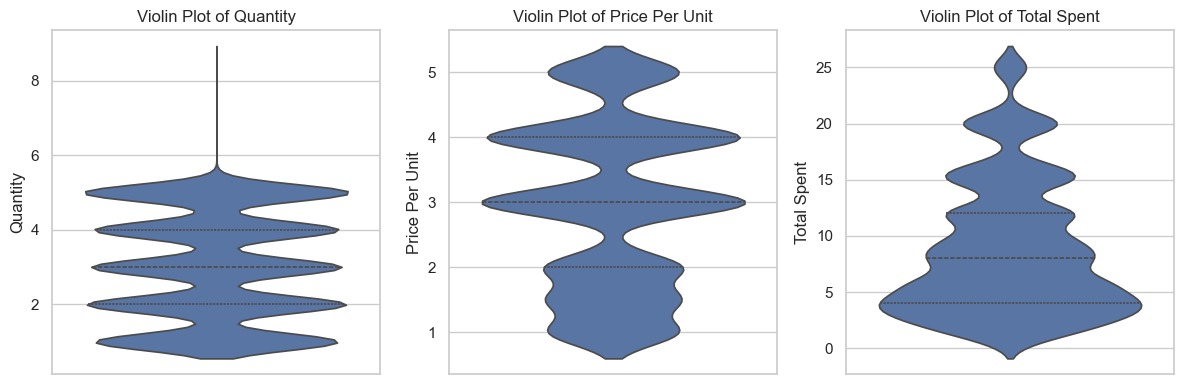

In [36]:
# Plot violin plots
plt.figure(figsize=(12, 4))
for i, col in enumerate(['Quantity', 'Price Per Unit', 'Total Spent'], 1):
    plt.subplot(1, 3, i)
    sns.violinplot(y=df[col], inner="quartile")
    plt.title(f"Violin Plot of {col}")

plt.tight_layout()
plt.show()


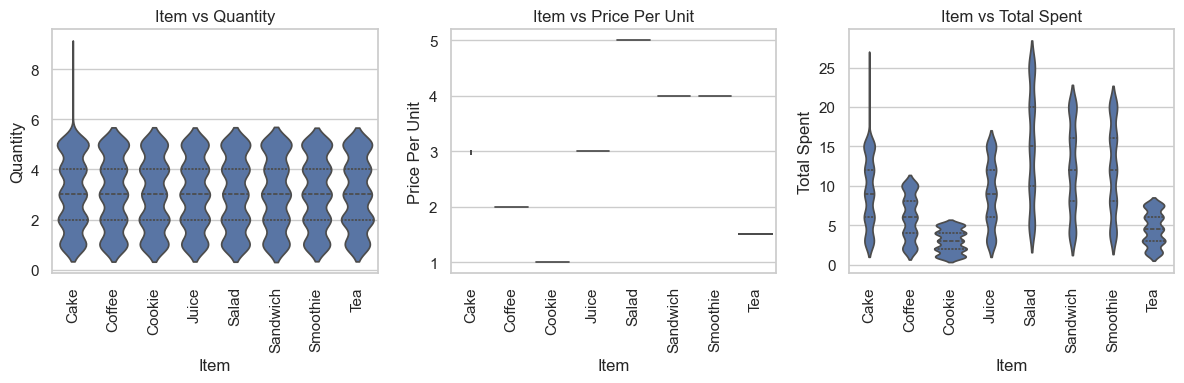

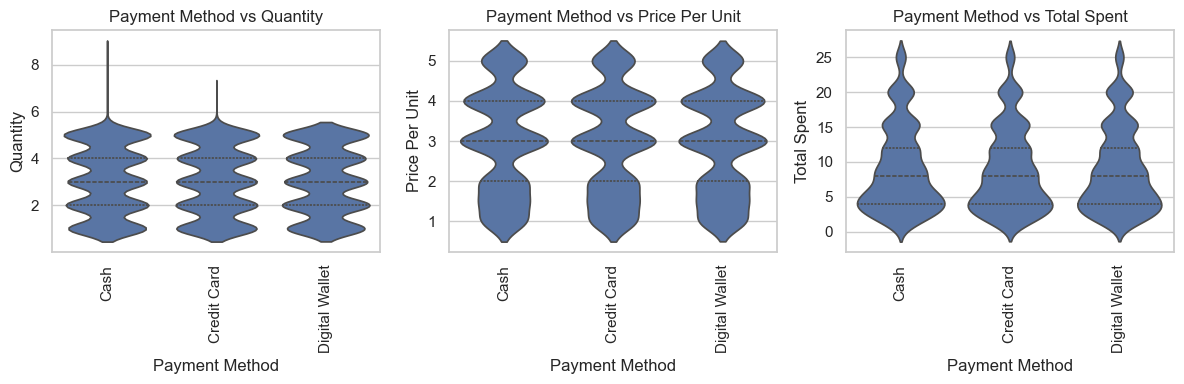

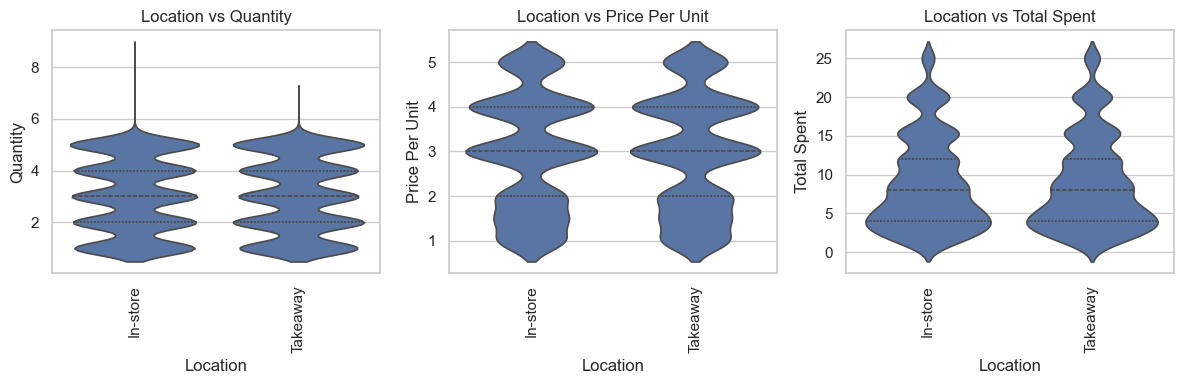

In [38]:
# Plot violin plots for categorical variables vs numerical features
categorical_vars = ['Item', 'Payment Method', 'Location']
numerical_vars = ['Quantity', 'Price Per Unit', 'Total Spent']

for cat in categorical_vars:
    plt.figure(figsize=(12, 4))
    for i, num in enumerate(numerical_vars, 1):
        plt.subplot(1, 3, i)
        sns.violinplot(x=df[cat], y=df[num], inner="quartile")
        plt.xticks(rotation=90)
        plt.title(f"{cat} vs {num}")
    plt.tight_layout()
    plt.show()

# Multivariate Analysis

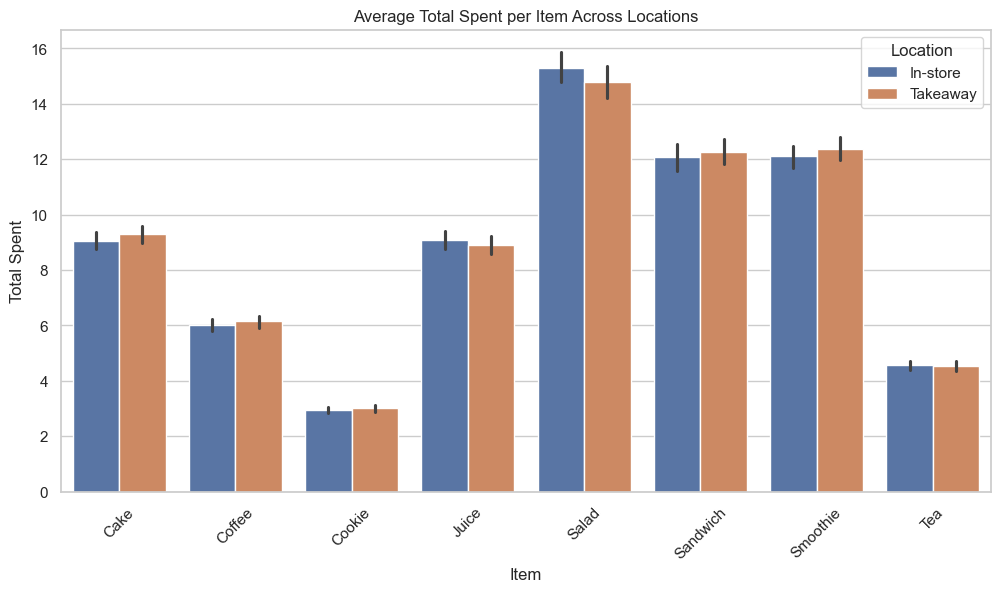

In [32]:
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Item", y="Total Spent", hue="Location", data=df, estimator=np.mean)
    plt.xticks(rotation=45)
    plt.title("Average Total Spent per Item Across Locations")
    plt.show()

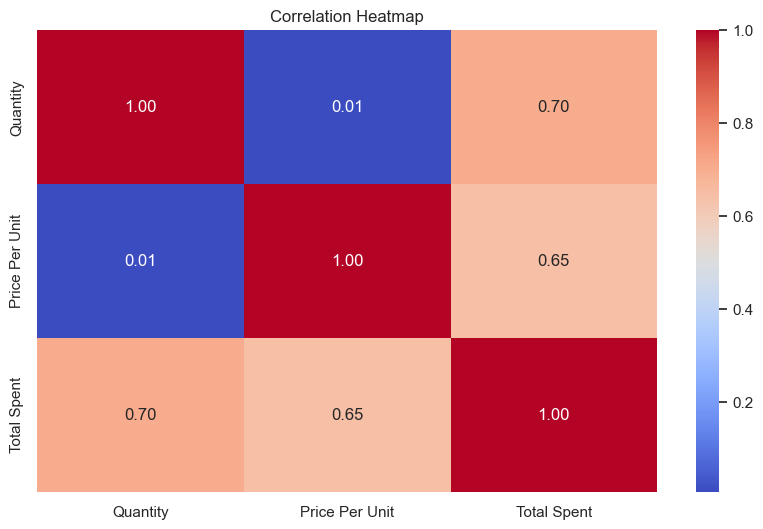

In [31]:
# Heatmap of correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

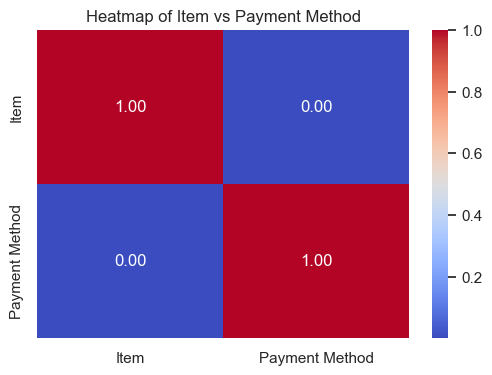

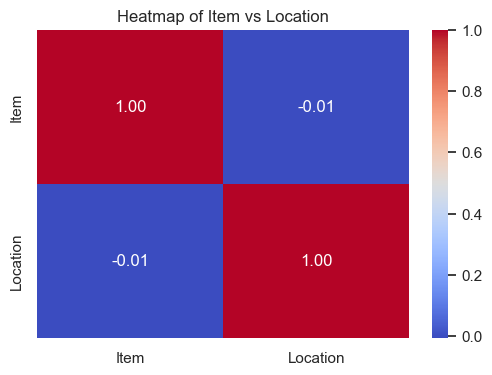

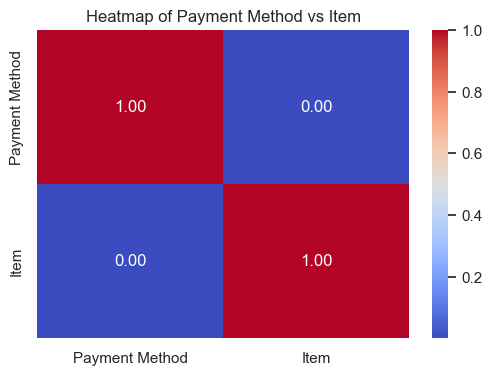

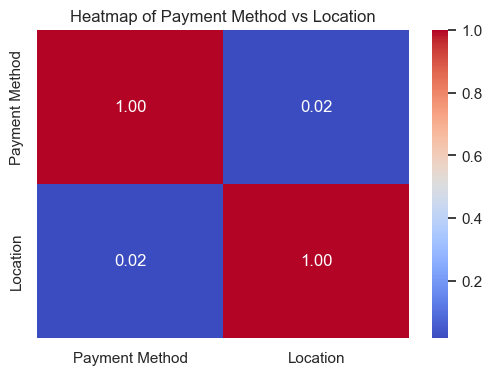

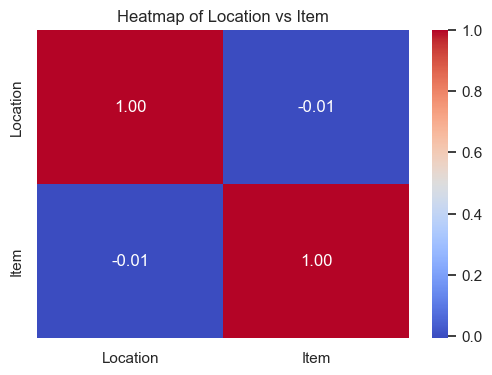

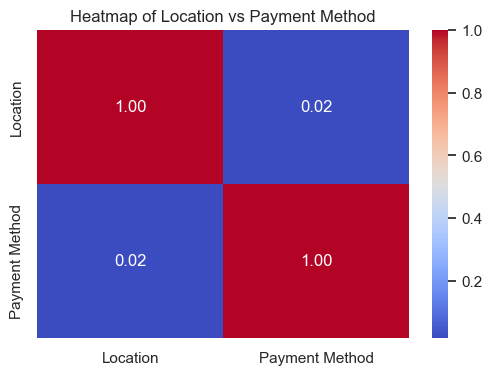

In [44]:
# Heatmaps for categorical vs categorical variables
cat_corr_matrix = encoded_df[categorical_vars].corr()
for cat1 in categorical_vars:
    for cat2 in categorical_vars:
        if cat1 != cat2:
            plt.figure(figsize=(6, 4))
            sns.heatmap(encoded_df[[cat1, cat2]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
            plt.title(f"Heatmap of {cat1} vs {cat2}")
            plt.show()

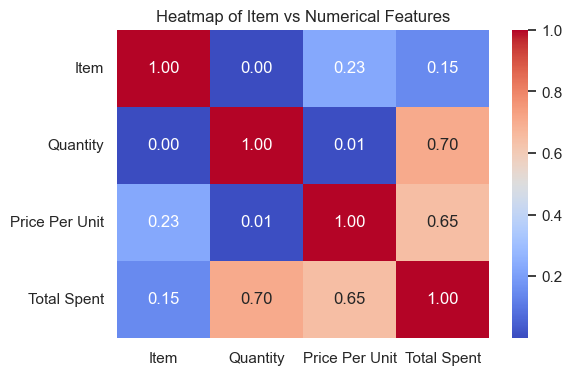

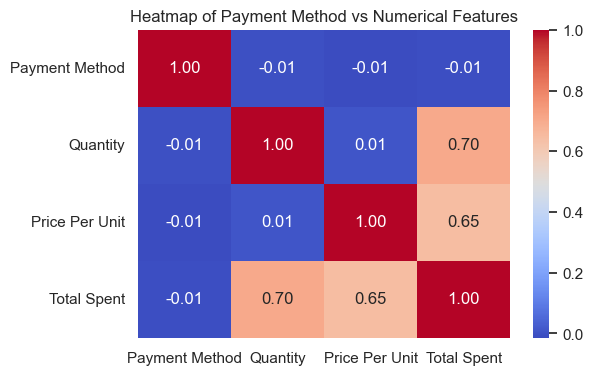

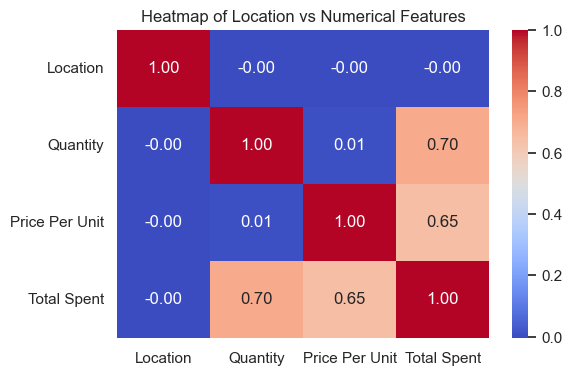

In [40]:
# Encode categorical variables and compute correlations separately
encoded_df = df.copy()
for cat in categorical_vars:
    encoded_df[cat] = encoded_df[cat].astype('category').cat.codes
    corr_matrix_cat = encoded_df[[cat] + numerical_vars].corr()
    
    # Plot heatmap for each categorical variable
    plt.figure(figsize=(6, 4))
    sns.heatmap(corr_matrix_cat, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(f"Heatmap of {cat} vs Numerical Features")
    plt.show()

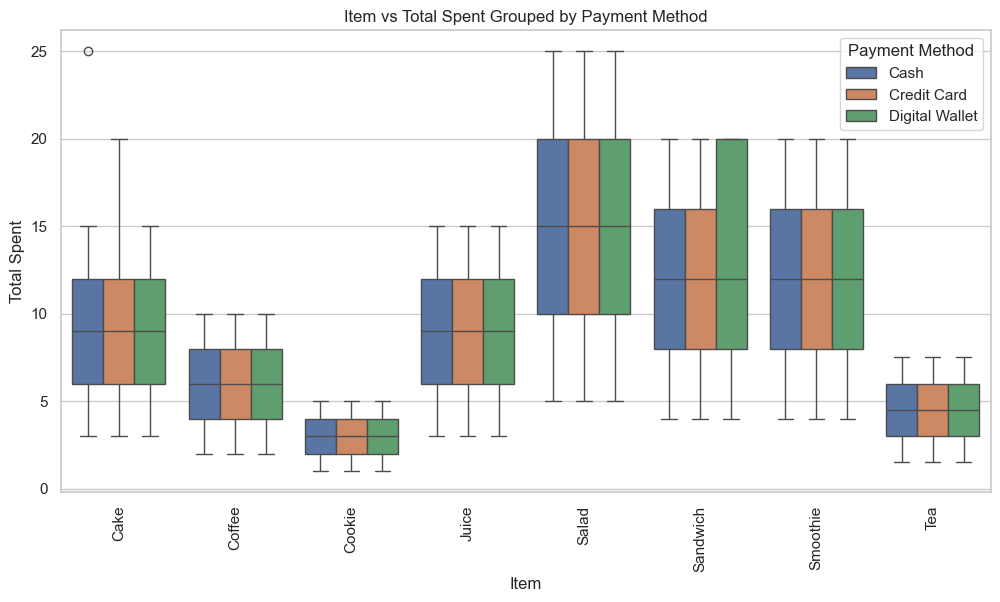

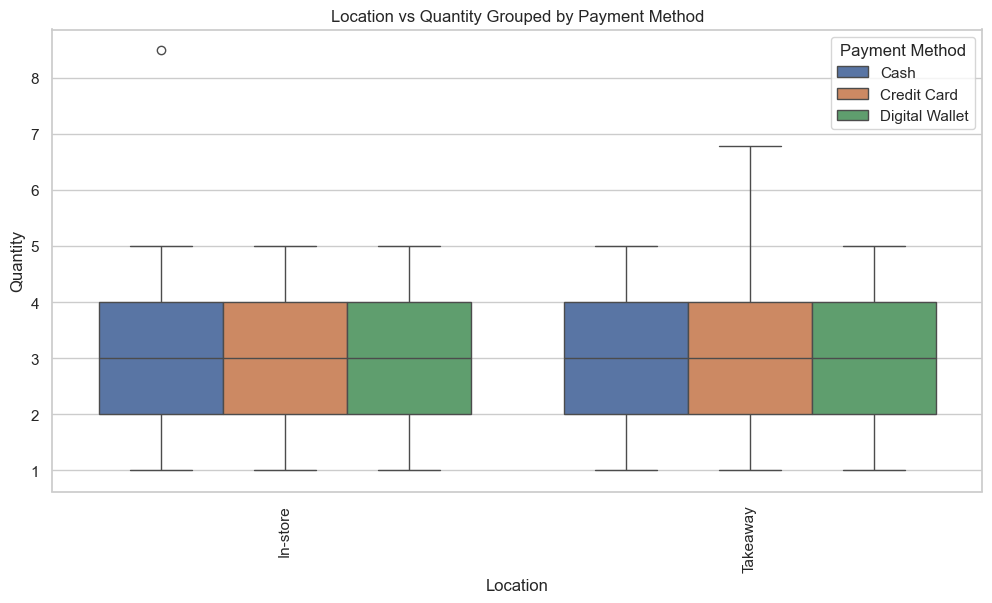

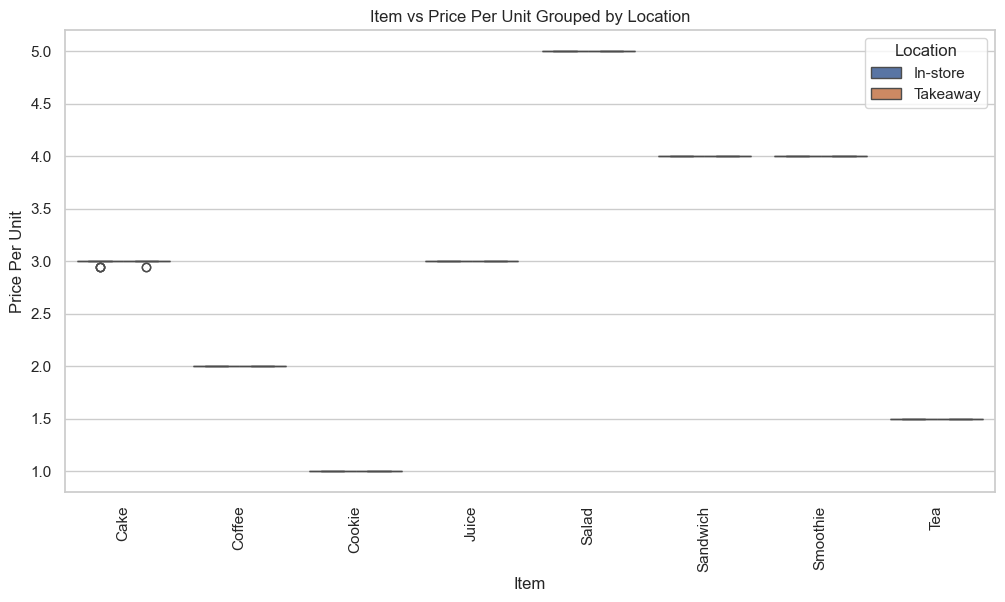

In [41]:
# Grouped comparisons to identify combined effects of multiple features
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Item'], y=df['Total Spent'], hue=df['Payment Method'])
plt.xticks(rotation=90)
plt.title("Item vs Total Spent Grouped by Payment Method")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Location'], y=df['Quantity'], hue=df['Payment Method'])
plt.xticks(rotation=90)
plt.title("Location vs Quantity Grouped by Payment Method")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Item'], y=df['Price Per Unit'], hue=df['Location'])
plt.xticks(rotation=90)
plt.title("Item vs Price Per Unit Grouped by Location")
plt.show()

In [55]:
# Analysis of second semester sales in 2023
df_last_6_months = df[
    (df['Transaction Date'] >= '2023-07-01') & (df['Transaction Date'] <= '2023-12-31')]
df_last_6_months["Transaction Date"].describe()

count                             4996
mean     2023-09-30 04:30:56.204964096
min                2023-07-01 00:00:00
25%                2023-08-15 00:00:00
50%                2023-10-01 00:00:00
75%                2023-11-14 00:00:00
max                2023-12-31 00:00:00
Name: Transaction Date, dtype: object

In [56]:
# Create 'Month' column avoiding SettingWithCopyWarning
df_last_6_months.loc[:, 'Month Name'] = df_last_6_months['Transaction Date'].dt.month_name()

df_last_6_months["Month Name"].describe()

count        4996
unique          6
top       October
freq          879
Name: Month Name, dtype: object

In [57]:
month_order = ['July', 'August', 'September', 'October', 'November', 'December']

monthly_item_sales = df_last_6_months.groupby(['Month Name', 'Item'], 
                                              observed=False)['Quantity'].sum().reset_index()

monthly_item_sales['Month Name'] = pd.Categorical(monthly_item_sales['Month Name'], categories=month_order, ordered=True)
monthly_item_sales = monthly_item_sales.sort_values('Month Name')

print(monthly_item_sales.head())

   Month Name      Item  Quantity
23       July       Tea   299.037
22       July  Smoothie   319.000
21       July  Sandwich   271.000
20       July     Salad   383.000
19       July     Juice   216.000


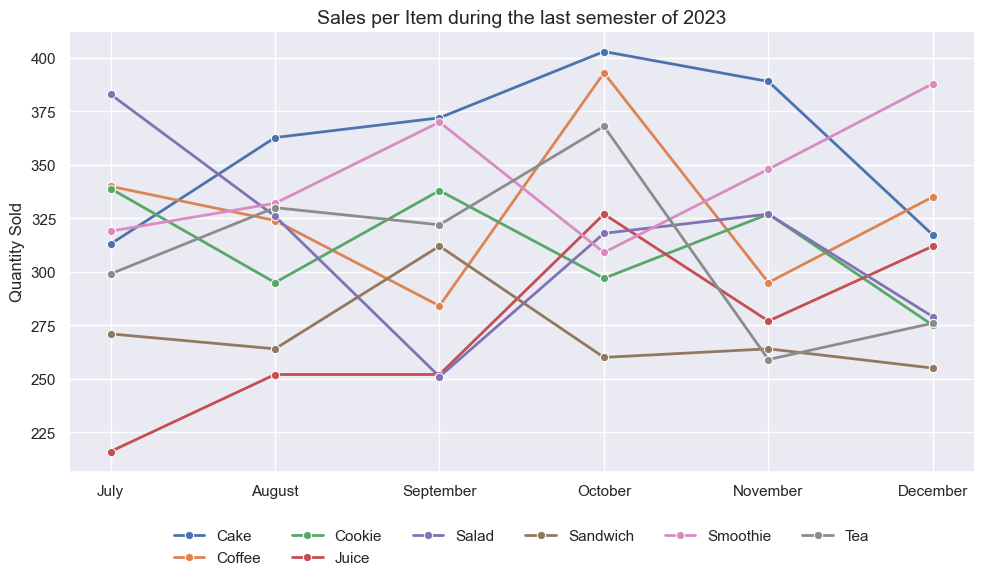

In [58]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=monthly_item_sales, x='Month Name', y='Quantity', hue='Item', marker='o', linewidth=2)

# Plot title and labels
plt.title('Sales per Item during the last semester of 2023', fontsize=14)
plt.xlabel('')
plt.ylabel('Quantity Sold', fontsize=12)

# Full width bottom legend
plt.legend(title='', 
           loc='upper center', 
           bbox_to_anchor=(0.5, -0.1), 
           ncol=6, 
           frameon=False)

# Remove the top and right borders of the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Display the plot
plt.tight_layout()  # Ensure everything fits without overlapping
plt.show()